In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json

from ms_pred import common
from ms_pred.common import plot_utils
from ms_pred.common.plot_utils import *
import copy

set_style()


%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_names = ["nist20", "canopus_train_public"]
# results_folder = Path("../results/figs/")
results_folder = Path("../results/figs_scarf/retrieval")
results_folder.mkdir(parents=True, exist_ok=True)
label_files = [f"../data/spec_datasets/{i}/labels.tsv" for i in dataset_names]
spec_to_smiles = {
    j[0]: j[1]
    for i in label_files
    for j in pd.read_csv(i, sep="\t")[["spec", "smiles"]].values
}

In [3]:
names = [
    "Random",
    "3DMolMS",
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF",
]
dataset_to_res = {}
for dataset_name in dataset_names:
    results_files = [
        f"../results/dag_inten_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_random.yaml",
        f"../results/molnetms_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        f"../results/graff_ms_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        f"../results/ffn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        f"../results/gnn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        f"../results/scarf_inten_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        f"../results/dag_inten_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    dataset_to_res[dataset_name] = yaml_files

In [4]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1, 11)}

for dataset, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k,
                "Top k": new_name,
                "Acc": v[old_name],
                "Dataset": dataset,
            }
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [5]:
for dataset_name in dataset_names:
    # Filter out df to specific dataset
    df = out_df[out_df["Dataset"] == dataset_name]
    pivoted_tbl = df.reset_index().pivot_table(
        index="Method", values="Acc", columns="Top k"
    )
    pivoted_tbl.index.name = None
    pivoted_tbl = pivoted_tbl.round(3)
    pivoted_tbl = pivoted_tbl.loc[names]

    display(pivoted_tbl)
    latex = pivoted_tbl.to_latex(
        caption=f"{dataset_name} spectra prediction retrieval accuracy",
        label=f"tab:{dataset_name}_spec_retrieval",
    )
    print(latex)

Top k,1,2,3,4,5,6,7,8,9,10
Random,0.027,0.053,0.079,0.102,0.126,0.150,0.170,0.191,0.209,0.230
3DMolMS,0.052,0.106,0.152,0.196,0.233,0.269,0.309,0.342,0.373,0.405
FixedVocab,0.171,0.307,0.397,0.465,0.518,0.556,0.598,0.631,0.657,0.687
NEIMS (FFN),0.102,0.230,0.311,0.376,0.425,0.469,0.506,0.543,0.574,0.602
NEIMS (GNN),0.174,0.301,0.391,0.467,0.523,0.570,0.609,0.642,0.671,0.700
SCARF,0.177,0.309,0.420,0.491,0.542,0.582,0.613,0.640,0.671,0.705


\begin{table}
\centering
\caption{nist20 spectra prediction retrieval accuracy}
\label{tab:nist20_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\toprule
Top k &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 \\
\midrule
Random      &  0.027 &  0.053 &  0.079 &  0.102 &  0.126 &  0.150 &  0.170 &  0.191 &  0.209 &  0.230 \\
3DMolMS     &  0.052 &  0.106 &  0.152 &  0.196 &  0.233 &  0.269 &  0.309 &  0.342 &  0.373 &  0.405 \\
FixedVocab  &  0.171 &  0.307 &  0.397 &  0.465 &  0.518 &  0.556 &  0.598 &  0.631 &  0.657 &  0.687 \\
NEIMS (FFN) &  0.102 &  0.230 &  0.311 &  0.376 &  0.425 &  0.469 &  0.506 &  0.543 &  0.574 &  0.602 \\
NEIMS (GNN) &  0.174 &  0.301 &  0.391 &  0.467 &  0.523 &  0.570 &  0.609 &  0.642 &  0.671 &  0.700 \\
SCARF       &  0.177 &  0.309 &  0.420 &  0.491 &  0.542 &  0.582 &  0.613 &  0.640 &  0.671 &  0.705 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_1814193/1775868083.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


Top k,1,2,3,4,5,6,7,8,9,10
Random,0.032,0.062,0.093,0.115,0.138,0.159,0.186,0.212,0.233,0.256
3DMolMS,0.100,0.166,0.230,0.276,0.320,0.367,0.406,0.442,0.470,0.495
FixedVocab,0.199,0.325,0.400,0.472,0.515,0.540,0.572,0.596,0.610,0.637
NEIMS (FFN),0.199,0.316,0.384,0.436,0.488,0.533,0.567,0.595,0.621,0.640
NEIMS (GNN),0.180,0.291,0.376,0.422,0.468,0.512,0.538,0.575,0.600,0.626
SCARF,0.133,0.230,0.299,0.372,0.424,0.479,0.510,0.556,0.589,0.612


\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\toprule
Top k &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 \\
\midrule
Random      &  0.032 &  0.062 &  0.093 &  0.115 &  0.138 &  0.159 &  0.186 &  0.212 &  0.233 &  0.256 \\
3DMolMS     &  0.100 &  0.166 &  0.230 &  0.276 &  0.320 &  0.367 &  0.406 &  0.442 &  0.470 &  0.495 \\
FixedVocab  &  0.199 &  0.325 &  0.400 &  0.472 &  0.515 &  0.540 &  0.572 &  0.596 &  0.610 &  0.637 \\
NEIMS (FFN) &  0.199 &  0.316 &  0.384 &  0.436 &  0.488 &  0.533 &  0.567 &  0.595 &  0.621 &  0.640 \\
NEIMS (GNN) &  0.180 &  0.291 &  0.376 &  0.422 &  0.468 &  0.512 &  0.538 &  0.575 &  0.600 &  0.626 \\
SCARF       &  0.133 &  0.230 &  0.299 &  0.372 &  0.424 &  0.479 &  0.510 &  0.556 &  0.589 &  0.612 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_1814193/1775868083.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


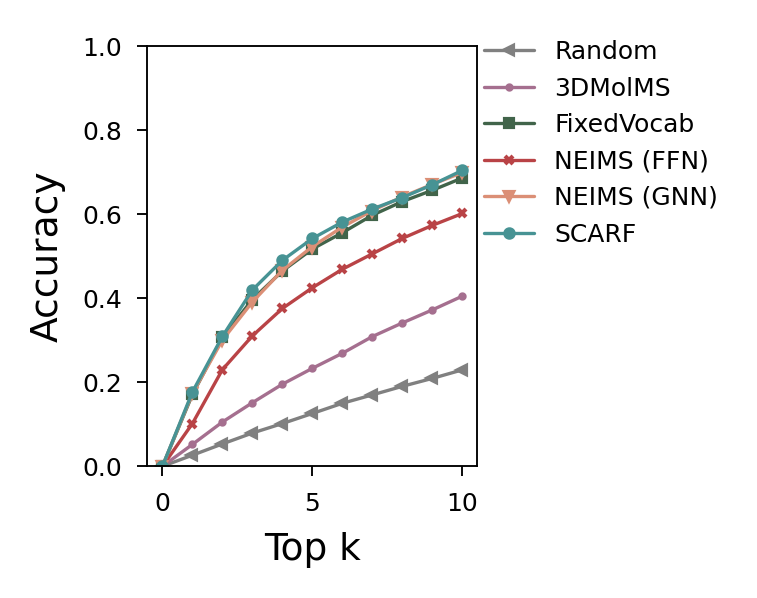

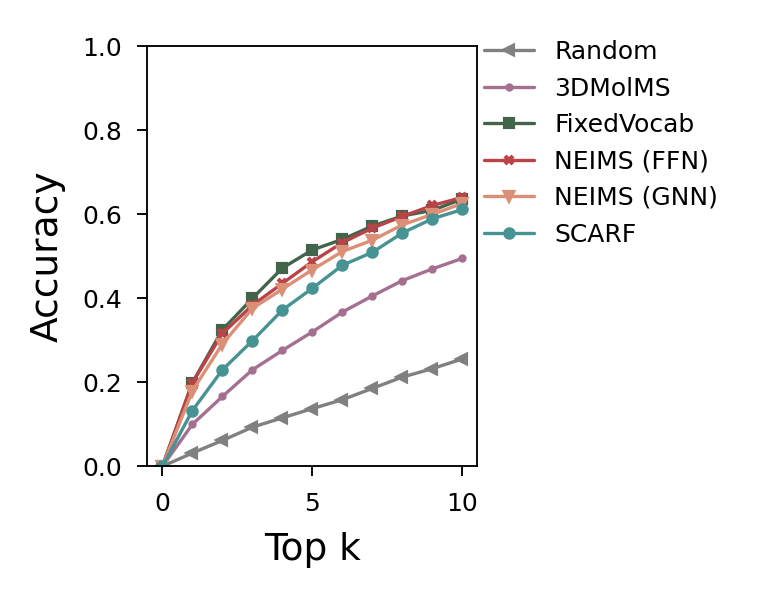

In [6]:
out_df_full = out_df.copy()
method_names = names
for dataset_name in dataset_names:
    sub_df = out_df[out_df["Dataset"] == dataset_name]
    # method_linestyle = dict(zip(method_names, ["o", "v", "x"]))
    figsize = (1.1, 1.4)
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.gca()
    for method in method_names:
        sub_df_method = sub_df[sub_df["Method"] == method]
        topk = [0] + sub_df_method["Top k"].values.tolist()
        accs = [0] + sub_df_method["Acc"].values.tolist()
        # ax.step(topk, accs, color=method_colors[method],
        #         linewidth=0.8, where="pre"
        # )
        marker = method_markers[method]
        # print(marker)
        ax.plot(
            topk,
            accs,
            color=method_colors[method],
            linewidth=0.8,
            label=method,
            marker=marker,
            markersize=2,
        )

    ax.set_xlabel("Top k")
    ax.set_ylabel("Accuracy")
    # ax.set_xlim([-0.1,5.2])
    ax.set_ylim([0, 1.0])
    ax.legend(frameon=False, facecolor="none", fancybox=False, loc=(0.99, 0.5))
    set_size(*figsize, ax)
    fig.savefig(
        results_folder / f"step_plot_{dataset_name}.pdf",
        dpi=400,
        bbox_inches="tight",
        transparent=True,
    )

## Retrieval by mass

In [7]:
f1 = list(yaml_files.values())[0]
f1.keys()

dict_keys(['avg_top_1', 'avg_top_10', 'avg_top_2', 'avg_top_3', 'avg_top_4', 'avg_top_5', 'avg_top_6', 'avg_top_7', 'avg_top_8', 'avg_top_9', 'avg_total_decoys', 'avg_true_dist', 'data_folder', 'dataset', 'dist_fn', 'individuals'])

In [8]:
all_res = []
yaml_files["Random"]["individuals"][0].keys()
all_res = []
for dataset, yaml_files in dataset_to_res.items():
    for method_name, out_dict in yaml_files.items():
        for i, res in enumerate(out_dict["individuals"]):
            all_res.append(copy.deepcopy(res))
            all_res[-1]["method"] = method_name
            all_res[-1]["id"] = i
            all_res[-1]["dataset"] = dataset
df = pd.DataFrame(all_res)

In [9]:
df.keys()
mean_df = df.groupby(["method", "dataset", "mass_bin"])["top_1"].mean()
mean_df = mean_df.reset_index()
mean_df = mean_df[mean_df["dataset"] == "nist20"]
pivoted_tbl = mean_df.pivot_table(
    index="method", values="top_1", columns=["dataset", "mass_bin"]
)
pivoted_tbl.index.name = "Method"
pivoted_tbl = pivoted_tbl.round(3)
pivoted_tbl = pivoted_tbl.loc[names]
pivoted_tbl.columns.name = "Mass bin (Da)"
display(pivoted_tbl)
latex = pivoted_tbl.to_latex(
    caption=f"{dataset_name} spectra prediction retrieval accuracy",
    label=f"tab:{dataset_name}_spec_retrieval",
)
print(latex)

# Second df with counts
mean_df = df.groupby(["method", "dataset", "mass_bin"])["top_1"].count()
mean_df = mean_df.reset_index()
mean_df = mean_df[mean_df["dataset"] == "nist20"]
pivoted_tbl = mean_df.pivot_table(
    index="method", values="top_1", columns=["dataset", "mass_bin"]
)
pivoted_tbl.index.name = "Method"
pivoted_tbl = pivoted_tbl.round(3)
pivoted_tbl = pivoted_tbl.loc[names]
pivoted_tbl.columns.name = "Mass bin (Da)"
display(pivoted_tbl)
latex = pivoted_tbl.to_latex(
    caption=f"{dataset_name} spectra prediction retrieval accuracy",
    label=f"tab:{dataset_name}_spec_retrieval",
)
print(latex)

dataset      nist20                                                    \
mass_bin    0 - 200 200 - 300 300 - 400 400 - 500 500 - 600 600 - 700   
Method                                                                  
Random        0.011     0.027     0.023     0.036     0.000     0.107   
3DMolMS       0.045     0.031     0.051     0.085     0.054     0.161   
FixedVocab    0.162     0.180     0.158     0.189     0.186     0.161   
NEIMS (FFN)   0.112     0.122     0.083     0.065     0.101     0.089   
NEIMS (GNN)   0.155     0.193     0.156     0.183     0.186     0.161   
SCARF         0.183     0.194     0.149     0.176     0.163     0.232   

dataset                 
mass_bin    700 - 2000  
Method                  
Random           0.101  
3DMolMS          0.225  
FixedVocab       0.146  
NEIMS (FFN)      0.079  
NEIMS (GNN)      0.135  
SCARF            0.146

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrr}
\toprule
dataset & \multicolumn{7}{l}{nist20} \\
mass\_bin & 0 - 200 & 200 - 300 & 300 - 400 & 400 - 500 & 500 - 600 & 600 - 700 & 700 - 2000 \\
Method      &         &           &           &           &           &           &            \\
\midrule
Random      &   0.011 &     0.027 &     0.023 &     0.036 &     0.000 &     0.107 &      0.101 \\
3DMolMS     &   0.045 &     0.031 &     0.051 &     0.085 &     0.054 &     0.161 &      0.225 \\
FixedVocab  &   0.162 &     0.180 &     0.158 &     0.189 &     0.186 &     0.161 &      0.146 \\
NEIMS (FFN) &   0.112 &     0.122 &     0.083 &     0.065 &     0.101 &     0.089 &      0.079 \\
NEIMS (GNN) &   0.155 &     0.193 &     0.156 &     0.183 &     0.186 &     0.161 &      0.135 \\
SCARF       &   0.183 &     0.194 &     0.149 &     0.176 &     0.163 &     0.232 &      0

/tmp/ipykernel_1814193/382209690.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


dataset      nist20                                                    \
mass_bin    0 - 200 200 - 300 300 - 400 400 - 500 500 - 600 600 - 700   
Method                                                                  
Random          624      1358       900       387       129        56   
3DMolMS         624      1358       900       387       129        56   
FixedVocab      624      1358       900       387       129        56   
NEIMS (FFN)     624      1358       900       387       129        56   
NEIMS (GNN)     624      1358       900       387       129        56   
SCARF           624      1358       900       387       129        56   

dataset                 
mass_bin    700 - 2000  
Method                  
Random              89  
3DMolMS             89  
FixedVocab          89  
NEIMS (FFN)         89  
NEIMS (GNN)         89  
SCARF               89

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrr}
\toprule
dataset & \multicolumn{7}{l}{nist20} \\
mass\_bin & 0 - 200 & 200 - 300 & 300 - 400 & 400 - 500 & 500 - 600 & 600 - 700 & 700 - 2000 \\
Method      &         &           &           &           &           &           &            \\
\midrule
Random      &     624 &      1358 &       900 &       387 &       129 &        56 &         89 \\
3DMolMS     &     624 &      1358 &       900 &       387 &       129 &        56 &         89 \\
FixedVocab  &     624 &      1358 &       900 &       387 &       129 &        56 &         89 \\
NEIMS (FFN) &     624 &      1358 &       900 &       387 &       129 &        56 &         89 \\
NEIMS (GNN) &     624 &      1358 &       900 &       387 &       129 &        56 &         89 \\
SCARF       &     624 &      1358 &       900 &       387 &       129 &        56 &       

/tmp/ipykernel_1814193/382209690.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


## Plot example spectra

In [10]:
out_df = out_df.set_index("Method").round(3)
out_df.index.name = None

In [11]:
dataset_name = "nist20"
yaml_files = dataset_to_res[dataset_name]
scarf_inds = yaml_files["SCARF"]["individuals"]
gnn_inds = yaml_files["NEIMS (GNN)"]["individuals"]
scarf_spec_to_ind = {i["spec_name"]: i["ind_recovered"] for i in scarf_inds}
gnn_spec_to_ind = {i["spec_name"]: i["ind_recovered"] for i in gnn_inds}

In [12]:
scarf_better = [
    k for k, v in scarf_spec_to_ind.items() if v == 1 and v < gnn_spec_to_ind[k]
]

In [13]:
np.random.seed(2)
len(scarf_better)
ex_specs = np.random.choice(scarf_better, 5)
ex_specs = np.random.choice(list(scarf_spec_to_ind.keys()), 5)
print(ex_specs)
# ex_specs = ['nist_1788697', 'nist_1208536']

['nist_1358607' 'nist_1141222' 'nist_1476324' 'nist_1446402'
 'nist_1245686']


['nist_1358607' 'nist_1141222' 'nist_1476324' 'nist_1446402'
 'nist_1245686']


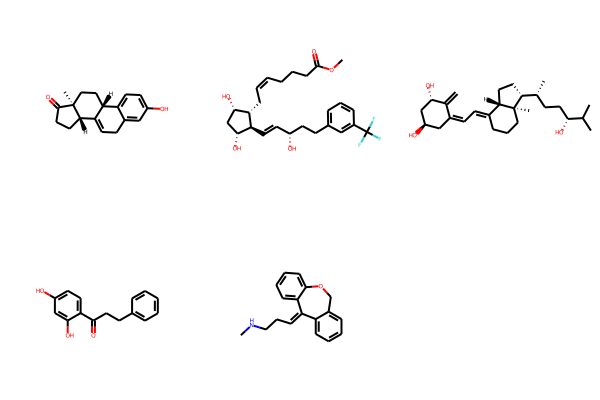

In [14]:
print(ex_specs)
mols = [Chem.MolFromSmiles(spec_to_smiles[i]) for i in ex_specs]
Draw.MolsToGridImage(
    mols,
)  # figsize=(20,10))

In [15]:
data_folder = Path(f"../data/spec_datasets/{dataset_name}/")

In [16]:
def export_ex_specs(
    ex_specs, folder_name="output_examples", add_numbers=True, figsize=(2.1, 1.4)
):
    spec_folder = results_folder / folder_name
    spec_folder.mkdir(exist_ok=True)

    for ex_spec in ex_specs:
        spec_file = data_folder / f"subformulae/no_subform/{ex_spec}.json"
        true_spec = json.load(open(spec_file, "r"))

        export_spec_folder = Path(
            f"../results/scarf_inten_{dataset_name}/split_1/preds_export_{dataset_name}/tree_preds_inten"
        )
        pred_spec_file = export_spec_folder / f"pred_{ex_spec}.json"
        pred_spec = json.load(open(pred_spec_file, "r"))
        print(pred_spec_file, spec_file)

        # Make predictions
        mz, inten = (
            pred_spec["output_tbl"]["formula_mass_no_adduct"],
            pred_spec["output_tbl"]["rel_inten"],
        )
        pred_forms = pred_spec["output_tbl"]["formula"]
        top_forms = np.argsort(inten)[::-1][:5]
        out_map = "\n".join(
            ["\t".join([str(j) for j in i]) for i in list(enumerate(pred_forms))]
        )
        out_info = f"Smiles: {pred_spec['smiles']}, Formula: {pred_spec['cand_form']}\n{out_map}"
        fig = plt.figure(figsize=(figsize), dpi=300)
        ax = fig.gca()
        inten = inten / np.max(inten)
        for ind, (m, i, pred_form) in enumerate(zip(mz, inten, pred_forms)):
            label_kwargs = {"label": "SCARF"} if ind == 0 else {}
            ax.vlines(
                x=m,
                ymin=0,
                ymax=i,
                color=method_colors.get("SCARF"),
                linewidth=0.5,
                **label_kwargs,
            )
            # Make form label
            if ind in top_forms and add_numbers:
                ax.text(x=m, y=i + 0.2, s=f"{ind}", fontsize=6, rotation=90)

        mz, inten = (
            true_spec["output_tbl"]["formula_mass_no_adduct"],
            true_spec["output_tbl"]["rel_inten"],
        )
        for ind, (m, i) in enumerate(zip(mz, inten)):
            label_kwargs = {"label": "True"} if ind == 0 else {}
            ax.vlines(
                x=m,
                ymin=0,
                ymax=-i,
                color="black",
                linewidth=0.5,
                **label_kwargs,
            )
        ax.axhline(y=0, xmin=0, xmax=1, color="black", linewidth=0.1)
        ax.set_xlabel("M/Z")
        ax.set_ylabel("Intensity")
        ax.set_title(f"Spectra: {ex_spec}")
        ax.set_ylim([-1.5, 1.5])
        ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
        ax.legend(**legend_params, loc="upper left")
        set_size(*figsize, ax)
        fig.savefig(
            spec_folder / f"{ex_spec}.pdf",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
        )
        with open(spec_folder / f"{ex_spec}.txt", "w") as fp:
            fp.write(out_info)
        mol_obj = Chem.MolFromSmiles(pred_spec["smiles"])
        plot_utils.export_mol(
            mol_obj, spec_folder / f"{ex_spec}_mol.pdf", width=100, height=100
        )

../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1358607.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1358607.json


/tmp/ipykernel_1814193/3816912252.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1141222.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1141222.json


/tmp/ipykernel_1814193/3816912252.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1476324.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1476324.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1446402.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1446402.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1245686.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1245686.json


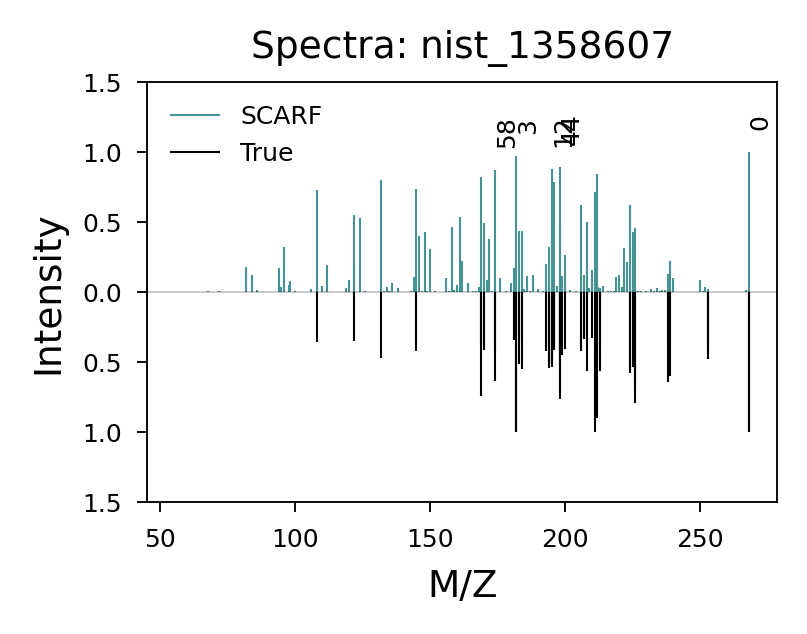

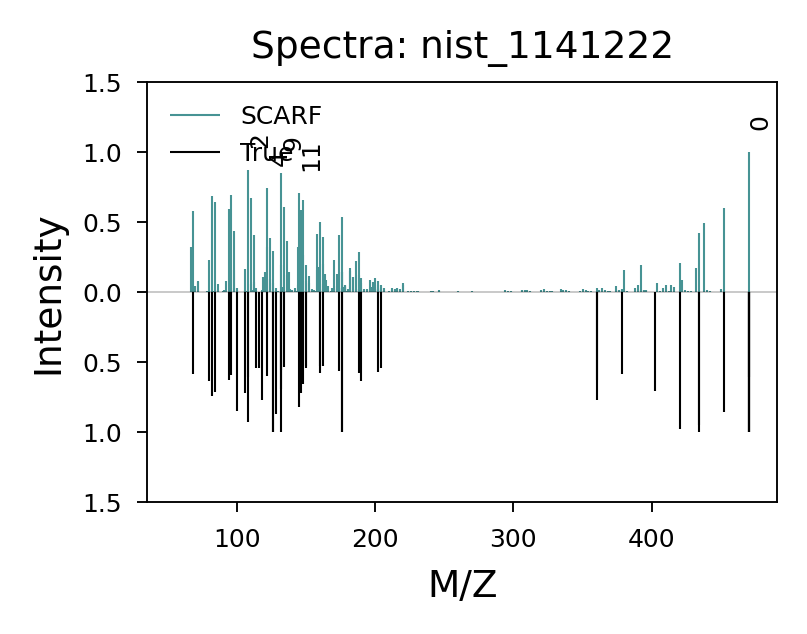

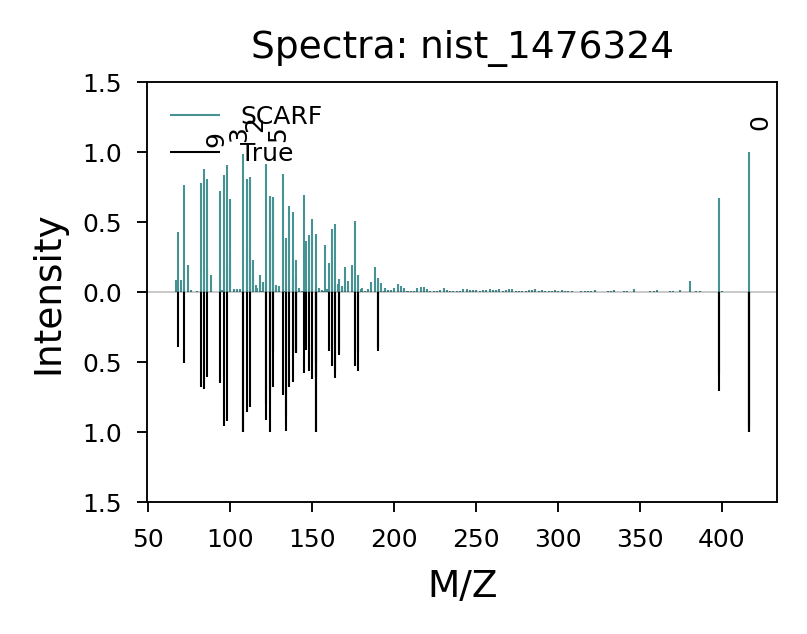

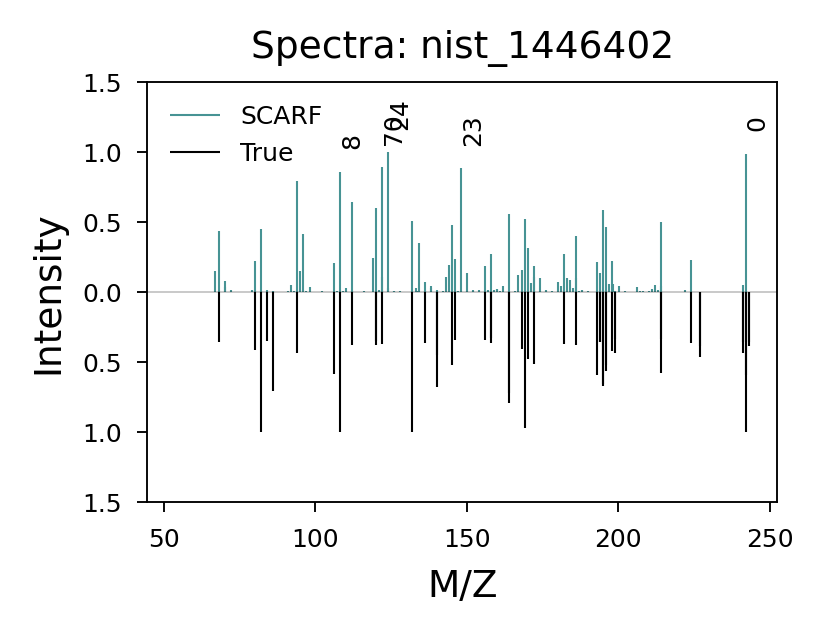

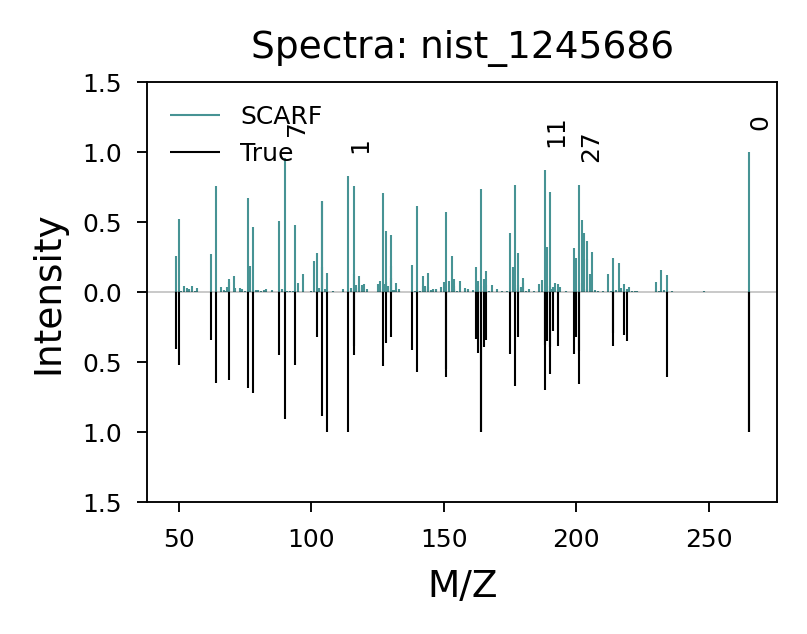

In [17]:
export_ex_specs(ex_specs=ex_specs)

../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1606579.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1606579.json


/tmp/ipykernel_1814193/3816912252.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_3352291.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_3352291.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1299793.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1299793.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1623045.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_1623045.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_3437230.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_3437230.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_3351801.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_3351801.json
../results/scarf_inten_nist20/split_1/preds_export_nist20/tree_preds_inten/pred_nist_1527827.json ../data/spec_datasets/nist20/subformulae/no_subform/nist_15278

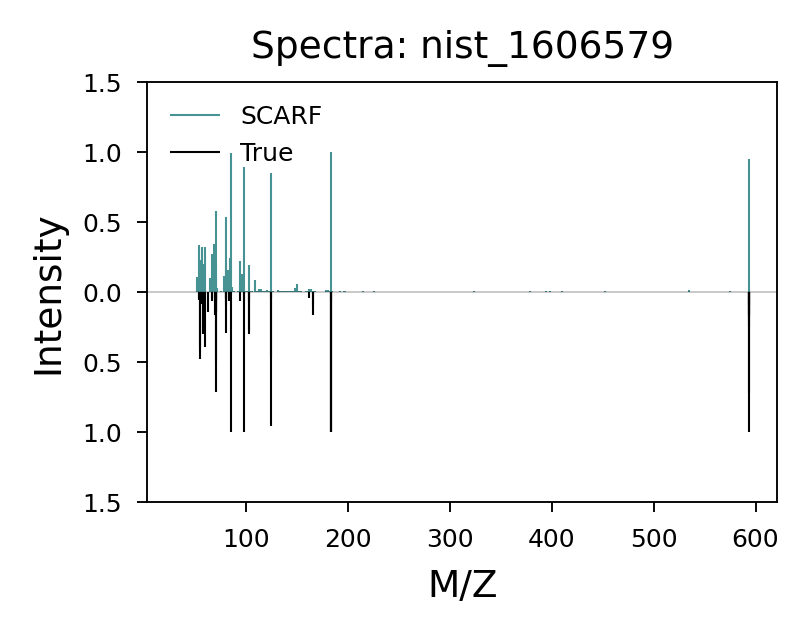

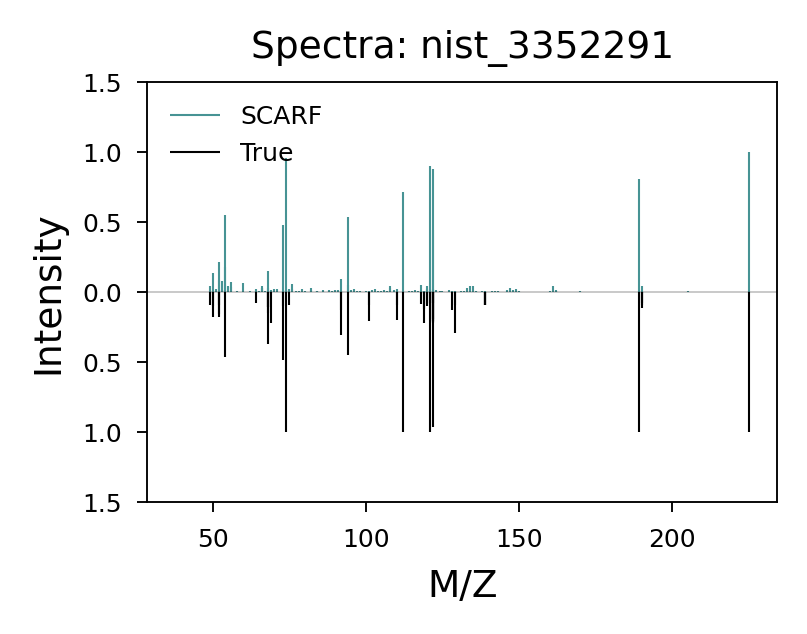

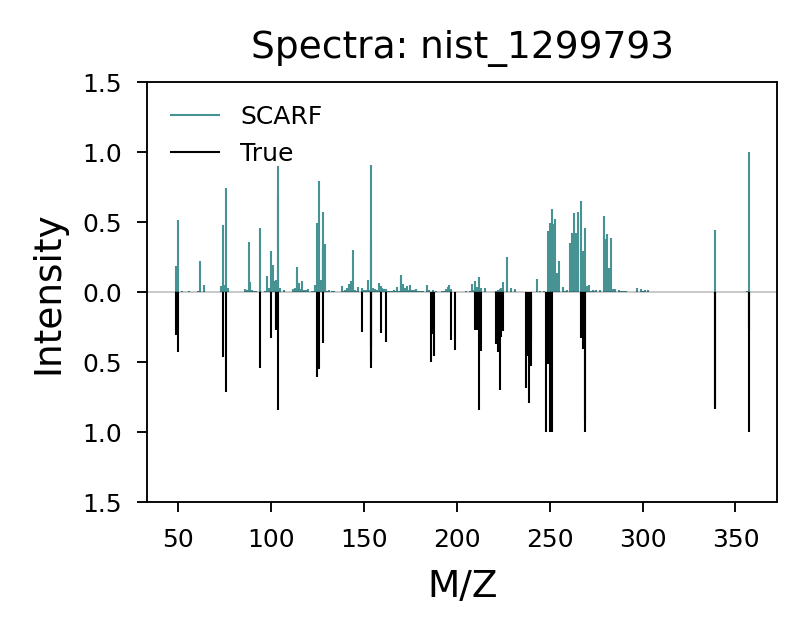

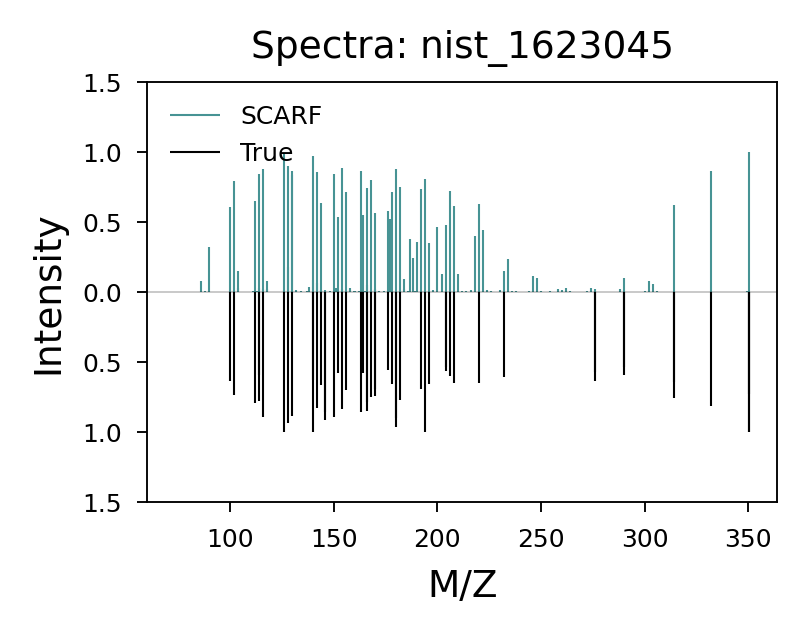

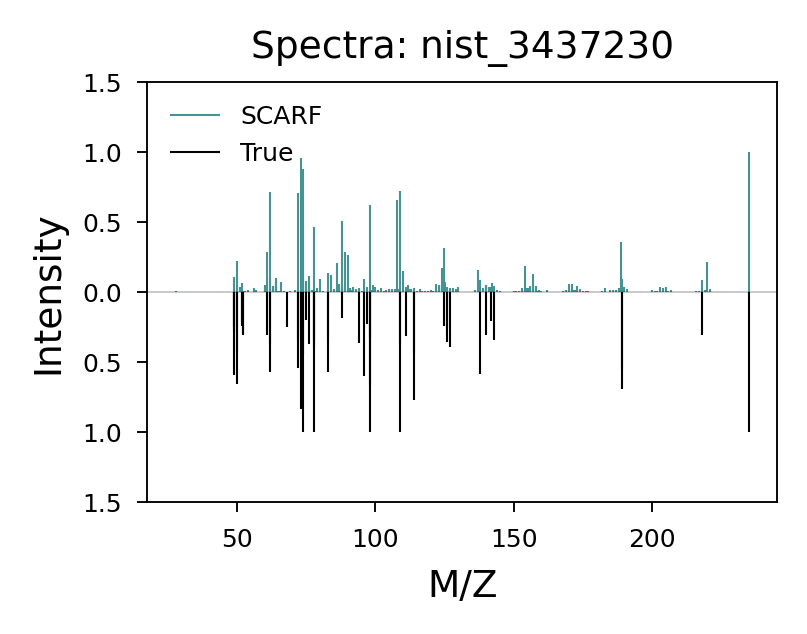

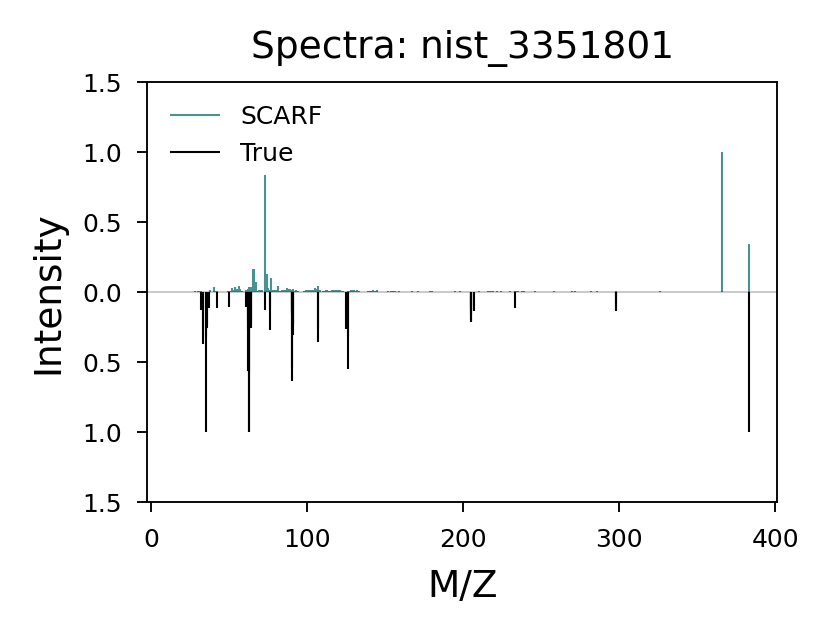

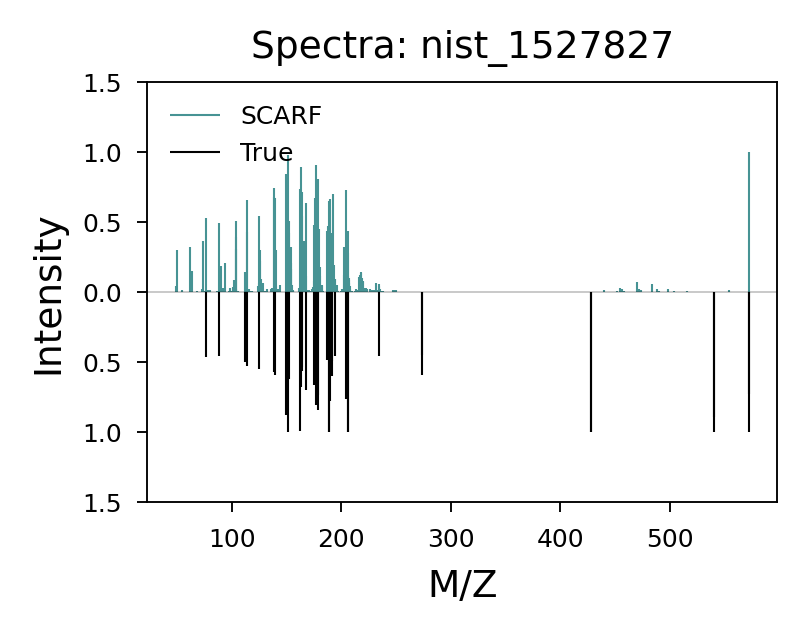

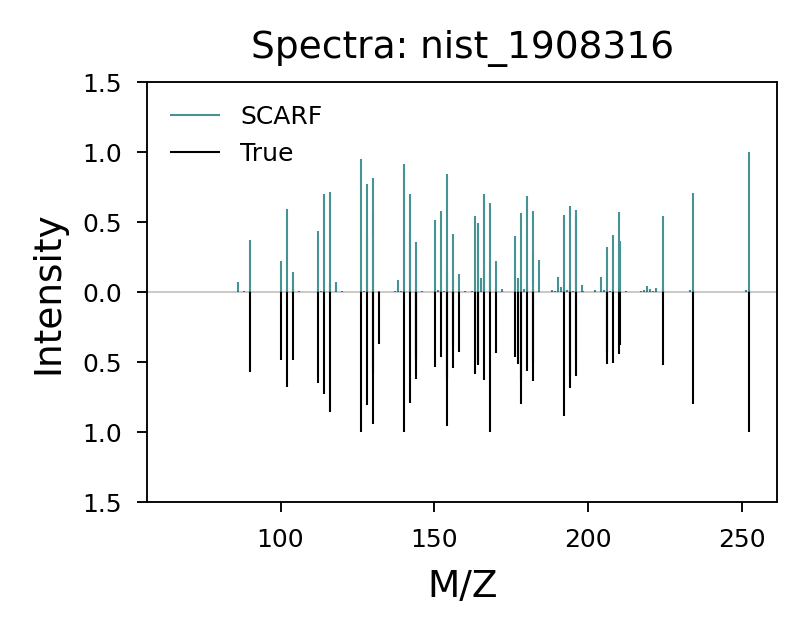

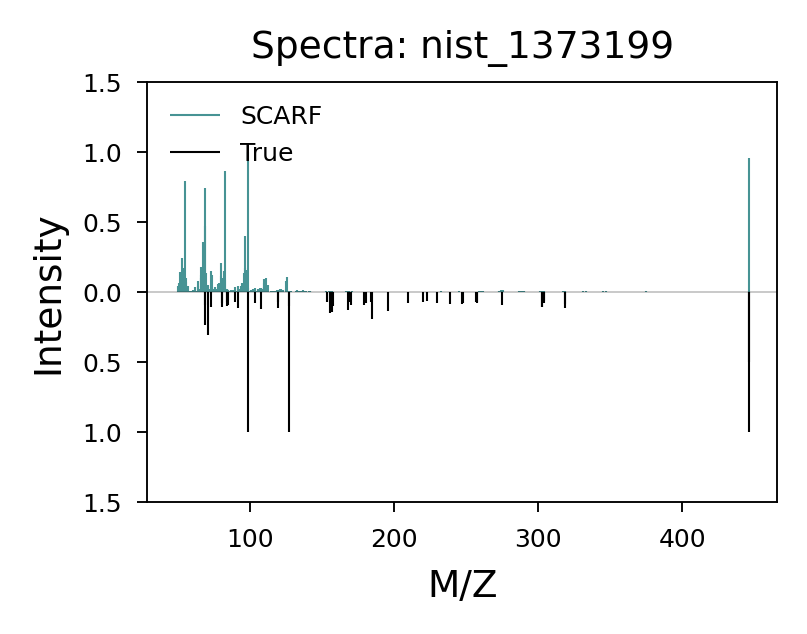

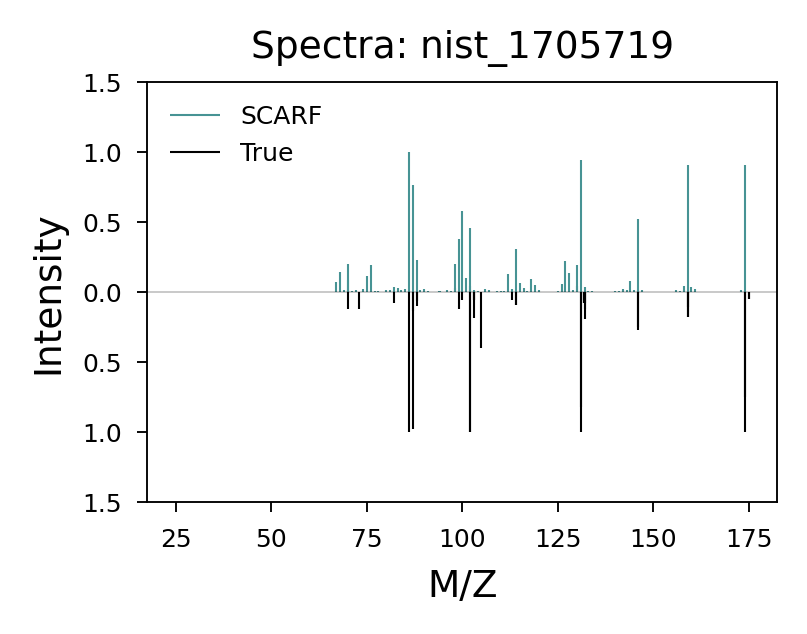

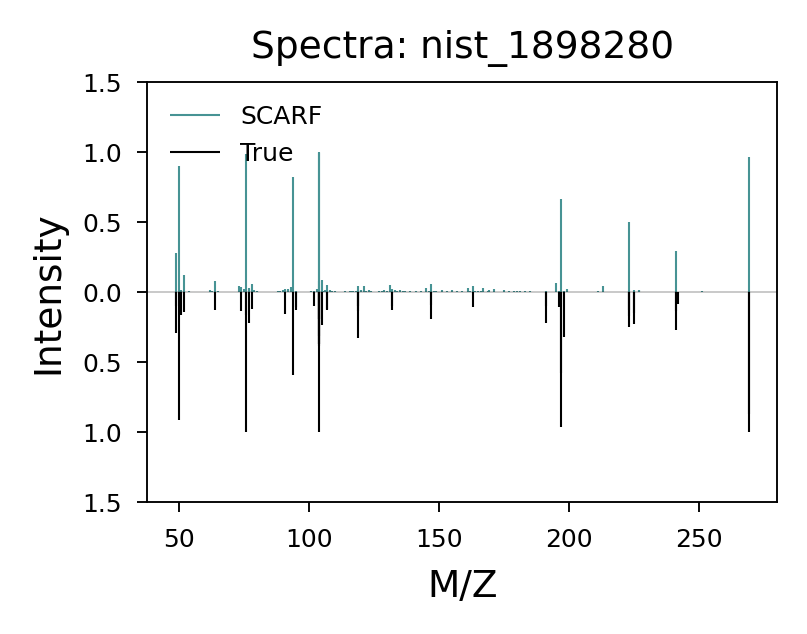

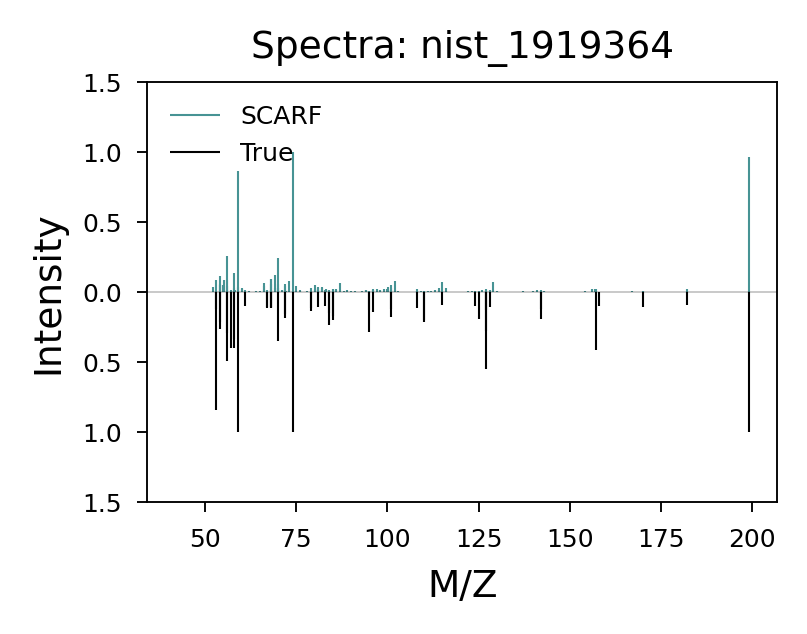

In [18]:
sorted_keys = sorted(list(scarf_spec_to_ind.keys()))
np.random.seed(10)
ex_specs = np.random.choice(sorted_keys, 12)
export_ex_specs(ex_specs=ex_specs, folder_name="si_specs", add_numbers=False)

## Retrieval full pubchem

In [26]:
dataset_name = "nist20"
names = [
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF",
]

root_dir  = Path("/data/DELETEME/samlg/DELETEME_2024_03_01_ms_pred_preprint_res/results/")
root_dir  = Path("../results/")
pubchem_inds = [50, None]
subsetnum = 500
res_dict = {}
for pubchem_num in pubchem_inds:
    results_files = [
        root_dir / f"graff_ms_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
        root_dir / f"ffn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
        root_dir / f"gnn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
        root_dir / f"scarf_inten_{dataset_name}/split_1/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    res_dict[f"{pubchem_num}"] = yaml_files

In [27]:
for k, yaml_files in res_dict.items():
    print(k)
    ind_df = pd.DataFrame([dict(model=k, **j) for k, v in yaml_files.items() for j in v["individuals"]])
    ind_df =  pd.DataFrame(ind_df.groupby(["model",   "ion"]).mean()['top_1'])
    ind_df = ind_df.reset_index()
    ind_df
    # Pivot so "ion" is on top and "model" is on the side
    pivoted_tbl = ind_df.pivot_table(
        index="model", values="top_1", columns="ion"
    )
    display(pivoted_tbl)

50


ion,[M+H-2H2O]+,[M+H-H2O]+,[M+H]+,[M+NH4]+,[M+Na]+
model,,,,,
FixedVocab,0.105263,0.107527,0.194719,0.333333,0.136986
NEIMS (FFN),0.052632,0.086022,0.125413,0.000000,0.068493
NEIMS (GNN),0.157895,0.086022,0.221122,0.166667,0.136986
SCARF,0.210526,0.107527,0.254125,0.000000,0.178082


None


ion,[M+H-2H2O]+,[M+H-H2O]+,[M+H]+,[M+NH4]+,[M+Na]+
model,,,,,
FixedVocab,0.105263,0.064516,0.174917,0.333333,0.136986
NEIMS (FFN),0.052632,0.064516,0.092409,0.000000,0.054795
NEIMS (GNN),0.157895,0.043011,0.174917,0.166667,0.123288
SCARF,0.210526,0.096774,0.201320,0.000000,0.136986


In [25]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1, 11)}

for dataset, yaml_files in res_dict.items():
    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k,
                "Top k": new_name,
                "Acc": v[old_name],
                "Dataset": dataset,
            }
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [22]:
out_df

,Method,Top k,Acc,Dataset
0,FixedVocab,1,0.192,50
1,FixedVocab,2,0.326,50
2,FixedVocab,3,0.410,50
3,FixedVocab,4,0.481,50
4,FixedVocab,5,0.532,50
...,...,...,...,...
75,SCARF,6,0.458,None
76,SCARF,7,0.492,None
77,SCARF,8,0.507,None
78,SCARF,9,0.527,None


In [23]:
out_df_temp = out_df.copy()
# Subset to where "Top k" in [1,2,3]
out_df_temp = out_df_temp[out_df_temp["Top k"].isin([1, 2, 3])]
out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns=["Dataset", "Top k"],
    values="Acc",
)  # aggfunc=lambda x: "&".join(x))

out_df_pivot_sorted = out_df_pivot.loc[names]
# out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {
    "nist20": 2,
    "canopus_train_public": 1,
}
dataset_order = ["canopus_train_public", "nist20"]


# Rename level 1 of column name to be "Pubchem limit"
out_df_pivot_sorted.columns.names = ["Pubchem limit", "Top k"]

# # Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(
    caption="Retrieval accuracy NIST20", label="tab:retrieval_acc_all", escape=False
)
print(latex)

Pubchem limit     50                 None              
Top k              1      2      3      1      2      3
FixedVocab     0.192  0.326  0.410  0.160  0.265  0.331
NEIMS (FFN)    0.103  0.236  0.315  0.082  0.175  0.233
NEIMS (GNN)    0.190  0.312  0.399  0.157  0.259  0.331
SCARF          0.200  0.323  0.452  0.146  0.239  0.341

\begin{table}
\centering
\caption{Retrieval accuracy NIST20}
\label{tab:retrieval_acc_all}
\begin{tabular}{lrrrrrr}
\toprule
Pubchem limit & \multicolumn{3}{l}{50} & \multicolumn{3}{l}{None} \\
Top k &      1 &      2 &      3 &      1 &      2 &      3 \\
\midrule
FixedVocab  &  0.192 &  0.326 &  0.410 &  0.160 &  0.265 &  0.331 \\
NEIMS (FFN) &  0.103 &  0.236 &  0.315 &  0.082 &  0.175 &  0.233 \\
NEIMS (GNN) &  0.190 &  0.312 &  0.399 &  0.157 &  0.259 &  0.331 \\
SCARF       &  0.200 &  0.323 &  0.452 &  0.146 &  0.239 &  0.341 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_1814193/1195466752.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(
